<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSCI 575: Advanced Machine Learning in the context of NLP applications. 


**Attribution:** This notebook is an adapted copy of [Jeff Heaton](https://sites.wustl.edu/jeffheaton/)'s excellent code and notes on [CNN-LSTM image captioning](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb).  

Highly recommended: Watch [Jeff Heaton's video](https://www.youtube.com/watch?v=NmoW_AYWkb4&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN). 

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.
  Running the following code will map your GDrive to ```/content/drive```.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Note: using Google CoLab


## What is image captioning? 


Image captioning combines LSTM text generation with convolutional neural network. This task was proposed in [Andrej Karpathy's Dissertation](https://cs.stanford.edu/people/karpathy/main.pdf). Images from his work are shown here:

![Captioning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/karpathy_thesis.jpg "Captioning")


## Tools we are going to use

- Keras and TensorFlow
- Transfer learning from the following two projects. 

  * [InceptionV3](https://arxiv.org/abs/1512.00567)
      * used to extract features from the images  
  * [GloVe](https://nlp.stanford.edu/projects/glove/)
      * pre-trained word embeddings


## Overview of caption generation 
The following diagram gives a high-level overview of how do we generate captions given a trained neural network.

![Captioning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/caption-1.png "Captioning")

We begin by importing the needed libraries.

## Image Captioning with Keras and TensorFlow

In [0]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

The following function is used to nicely format elapsed times.

In [0]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

### Needed Data

You will need to download the following data and place it in a folder for this example.  Point the *root_captioning* string at the folder that you are using for the caption generation. This folder should have the following sub-folders.

* data - Create this directory to hold saved models.
* [glove.6B](https://nlp.stanford.edu/projects/glove/) - Glove embeddings.
* [Flicker8k_Dataset](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip) - Flicker dataset.
* [Flicker8k_Text](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip)

Note, the original Flickr datasets are no longer available, but can be downloaded from [this article](https://machinelearningmastery.com/prepare-photo-caption-dataset-training-deep-learning-model/). 


### Google CoLab

If you are using Google CoLab then you will need to execute this cell.

In [4]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    root_captioning = "/content/drive/My Drive/Colab Notebooks/UBC-MDS-2019-20/Captioning/"
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Note: using Google CoLab


### Running Locally

In [0]:
if COLAB:
    root_captioning = "/content/drive/My Drive/projects/captions"
else:
    root_captioning = "./data/captions"

### Clean/Build Dataset From Flickr8k

- Read captions
- Preprocess captions
- For each image create a dictionary `lookup`, where keys are image ids and values are lists of captions associated with that image.  

In [0]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k_text','Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]


In [6]:
lookup['2052953131_30834196fb']

['person in black and red jacket walking up snowy mountain',
 'person is walking up snowy hill',
 'person wearing red jacket climbs snowy hill',
 'mountain climber climbing snowy mountaintop',
 'person in red and black parka climbing snow covered hill']

Stats on what was collected.

In [8]:
print(len(lookup)) # How many images? 
print(len(lex)) # How many unique words (vocab)
print(max_length) # Maximum length of a caption (in words)


8092
8763
32


## Load the images. 

In [0]:
# Warning, running this too soon on GDrive can sometimes not work.
# Just rerun if len(img) = 0
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))

Display the count of number of images

In [10]:
len(img)

8094

Read all image names and use the predefined train/test sets.

In [0]:
train_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

Display the size of the train and test sets.

In [12]:
print(len(train_images))
print(len(test_images))

6000
1000


Build the sequences.  We include a **start** and **stop** token at the beginning/end.  We will later use the **start** token to begin the process of generating a caption.  Encountering the **stop** token in the generated text will let us know we are done.

In [0]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

See how many discriptions were extracted.

In [16]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Choosing a Computer Vision Neural Network to Transfer

There are two neural networks that are accessed via transfer learning.  In this example, we use Glove for the text embedding and InceptionV3 to extract features from the images.  Both of these transfers serve to extract features from the raw text and the images.  Without this prior knowldge transferred in, this example would take consideraby more training.

You can interchange the neural network used for the images.  By setting the values WIDTH, HEIGHT, and OUTPUT_DIM you can interchange images.  One characteristic that you are seeking for the image neural network is that it does not have too many outputs (once you strip the 1000-class imagenet classifier, as is common in transfer learning).  InceptionV3 has 2,048 features below the classifier and MobileNet has over 50K.  If the additional dimensions truely capture aspects of the images, then they are worthwhile.  However, having 50K features increases the processing needed and the complexity of the neural network we are constructing.

In [18]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

96116736/96112376 [==============================] - 1s 0us/step


The summary for the chosen image neural network to be transfered is displayed.

In [19]:
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Creating the Training Set

We we need to encode the images to create the training set.  Later we will encode new images to present them for captioning.

In [0]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

We can how generate the training set.  This will involve looping over every JPG that was provied.  Because this can take awhile to perform we will save it to a pickle file.  This saves the considerable time needed to completly reprocess all of the images.  Because the images are processed differently by different transferred neural networks, the output dimensions are also made part of the file name.  If you changed from InceptionV3 to MobileNet, the number of output dimensions would change, and a new file would be created.

In [0]:
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

In [18]:
len(encoding_train)

6000

A similar process must also be performed for the test images.

In [0]:
test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

Next we separate the captions that will be using for training.  There are two sides to this training, the images and the captions.

In [23]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [24]:
all_train_captions[0]

'startseq child in pink dress is climbing up set of stairs in an entry way endseq'

Words that do not occur very often can be misleading to neural network training.  It is better to simply remove such words.  Here we remove any words that occur less than 10 times.  We display what the total vocabulary shrunk to.

In [21]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


Next we build two lookup tables for this vocabulary. One idxtoword convers index numbers to actual words to index values.  The wordtoidx lookup table performs the opposit.

In [22]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

Previously we added a start and stop token to all sentences.  We must account for this in the maximum length of captions.

In [23]:
max_length +=2
print(max_length)

34


### Using a Data Generator

Up to this point we've always generated training data ahead of time and fit the neural network to it.  It is not always practical to generate all of the training data ahead of time.  The memory demands can be considerable.  If the training data can be generated, as the neural network needs it, it is possable to use a Keras generator.  The generator will create new data, as it is needed.  The generator provided here creates the training data for the caption neural network, as it is needed.

If we were to build all needed training data ahead of time it would look something like below.

![Captioning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/caption-2.png "Captioning")

Here we are just training on two captions.  However, we would have to duplicate the image for each of these partial captions that we have.  Additionally the Flikr8K data set has 5 captions for each picture.  Those would all require duplication of data as well.  It is much more efficient to just generate the data as needed.

In [0]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1      
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

### Loading Glove Embeddings

In [25]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:23, 16982.84it/s]

Found 400000 word vectors.


### Building the Neural Network

An embedding matrix is built from Glove.  This will be directly copied to the weight matrix of the neural network.

In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

### The matrix makes sense.  It is 1652 (the size of the vocabulary) by 200 (the number of features Glove generates for each word).

In [0]:
# The first input is 2048 dimensional image features 
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Second input is a sequence (of size max length) we have created from our captions 
inputs2 = Input(shape=(max_length,))

# We pass it to the embedding layer
# mask_zero argument tells the network that some part of the data is actually
# padding and should be ignored. See here. s
# https://www.tensorflow.org/guide/keras/masking_and_padding
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)

# Our LSTM layer similar to what we had in text generation. 
se3 = LSTM(256)(se2)

# We add the image and LSTM information. 
decoder1 = add([fe2, se3])

# Pass it to a dense layer. 
decoder2 = Dense(256, activation='relu')(decoder1)

# Our final layer is a Dense layer with softmax activation. 
# Here we get probability distribution over all words in the vocabs
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [28]:
embedding_dim

200

In [29]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [31]:
len(train_descriptions), len(encoding_train)

(6000, 6000)

### Train the Neural Network

In [0]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)


### Generating Captions

It is important to understand that a caption is not generated with one single call to the neural network's predict function.  Neural networks output a fixed-length tensor.  To get a variable length output, such as free-form text, requires multiple calls to the neural network.

The neural network accepts two objects (which are mapped to the input neurons).  The first is the photo.  The second is an ever growing caption.  The caption begins with just the starting token.  The neural network's output is the prediction of the next word in the caption.  This continues until an end token is predicted or we reach the maximum length of a caption.  Each time predict a new word is predicted for the caption.  The word that has the highest probability (from the neural network) is chosen. 

In [0]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### Evaluate Performance on Test Data from Flicker8k

The caption model performs relativly well on images that are similar to what it trained on.

/content/drive/My Drive/Colab Notebooks/UBC-MDS-2019-20/Captioning/Flicker8k_Dataset/396360611_941e5849a3.jpg


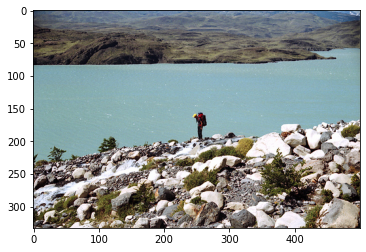

Caption: man stands on mountaintop overlooking the ocean
_____________________________________
/content/drive/My Drive/Colab Notebooks/UBC-MDS-2019-20/Captioning/Flicker8k_Dataset/398662202_97e5819b79.jpg


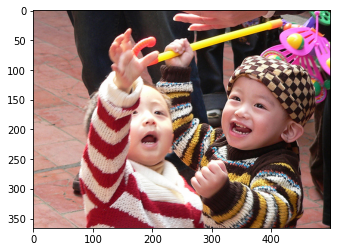

Caption: little girl in pink dress is playing with her hair
_____________________________________
/content/drive/My Drive/Colab Notebooks/UBC-MDS-2019-20/Captioning/Flicker8k_Dataset/401079494_562454c4d6.jpg


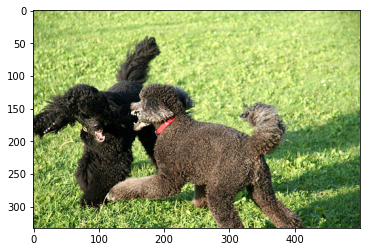

Caption: black poodle is running on the grass
_____________________________________
/content/drive/My Drive/Colab Notebooks/UBC-MDS-2019-20/Captioning/Flicker8k_Dataset/400851260_5911898657.jpg


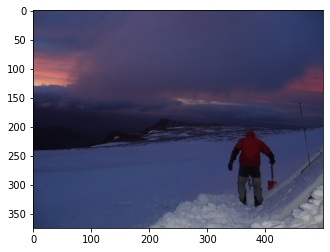

Caption: man in red jacket is standing on snowy mountain
_____________________________________
/content/drive/My Drive/Colab Notebooks/UBC-MDS-2019-20/Captioning/Flicker8k_Dataset/405615014_03be7ef618.jpg


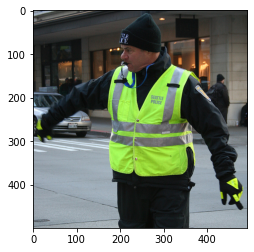

Caption: man in black shirt and hat is standing next to woman in black jacket
_____________________________________
/content/drive/My Drive/Colab Notebooks/UBC-MDS-2019-20/Captioning/Flicker8k_Dataset/410453140_5401bf659a.jpg


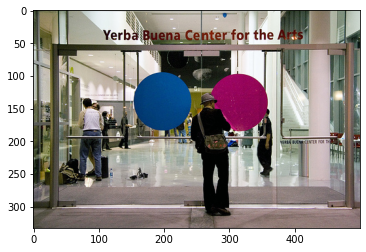

Caption: man in blue shirt and tie is walking down the street
_____________________________________
/content/drive/My Drive/Colab Notebooks/UBC-MDS-2019-20/Captioning/Flicker8k_Dataset/415793623_6c1225ae27.jpg


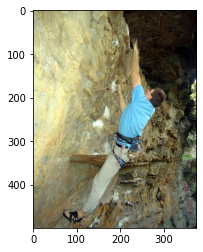

Caption: man climbing rock wall
_____________________________________
/content/drive/My Drive/Colab Notebooks/UBC-MDS-2019-20/Captioning/Flicker8k_Dataset/416106657_cab2a107a5.jpg


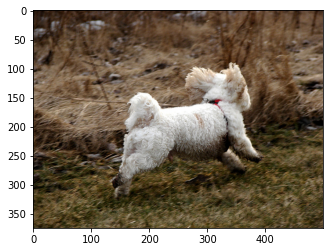

Caption: white dog with black spots runs across the grass
_____________________________________
/content/drive/My Drive/Colab Notebooks/UBC-MDS-2019-20/Captioning/Flicker8k_Dataset/416788726_5b4eb1466e.jpg


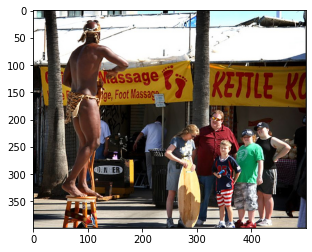

Caption: two women in skimpy outfits are dancing in front of volleyball court
_____________________________________
/content/drive/My Drive/Colab Notebooks/UBC-MDS-2019-20/Captioning/Flicker8k_Dataset/416960865_048fd3f294.jpg


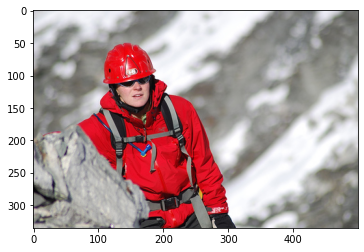

Caption: man in red jacket and helmet is skiing
_____________________________________


In [36]:
for z in range(10):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [37]:
encoding_test[pic].shape

(2048,)

### Evaluate Performance on My Own Photos 

In the "photos" folder of this GitHub repository I keep a collection of personal photos that I like to test neural networks on.  These are completly separate from the Flicker8K dataset and as a result, the caption neural network does not perform nearly as well.

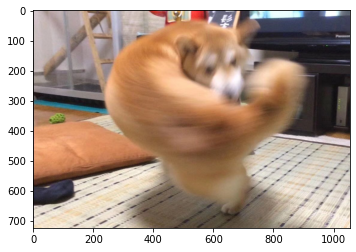

(1, 2048)
Caption: dog is jumping up to catch ball
_____________________________________


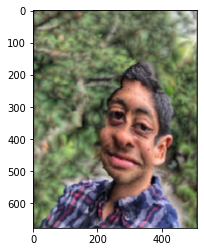

(1, 2048)
Caption: man in black shirt and woman in black shirt
_____________________________________


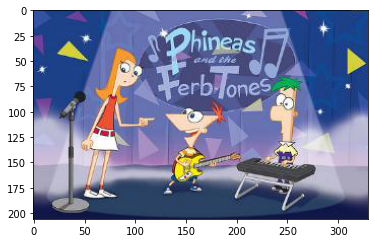

(1, 2048)
Caption: two men in red and white hats are riding on roller coaster
_____________________________________


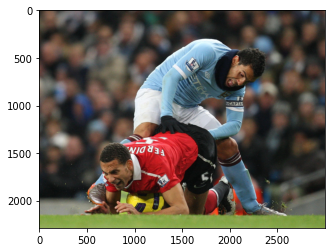

(1, 2048)
Caption: two men in athletic uniforms are running on field
_____________________________________


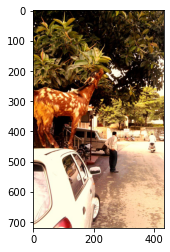

(1, 2048)
Caption: man in black shirt and jeans is walking past wooden bench
_____________________________________


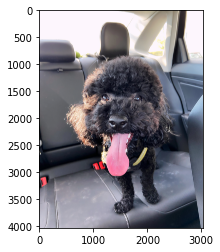

(1, 2048)
Caption: two black and white dogs are playing with red toy
_____________________________________


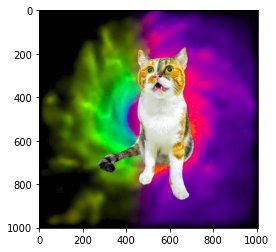

(1, 2048)
Caption: the dog is looking at the cat
_____________________________________


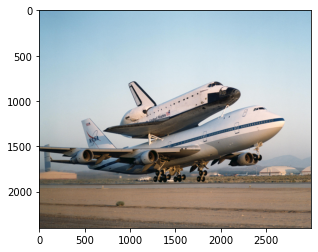

(1, 2048)
Caption: the dog is running through the grass
_____________________________________


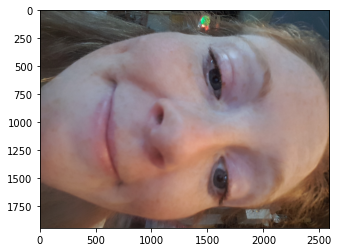

(1, 2048)
Caption: two children are sitting on bed
_____________________________________


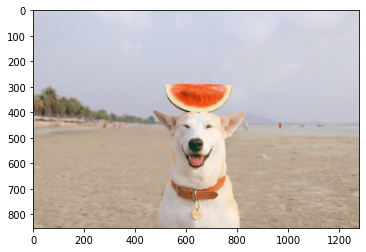

(1, 2048)
Caption: white dog is running on the beach
_____________________________________


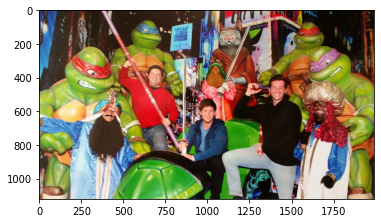

(1, 2048)
Caption: two people are riding on roller coaster
_____________________________________


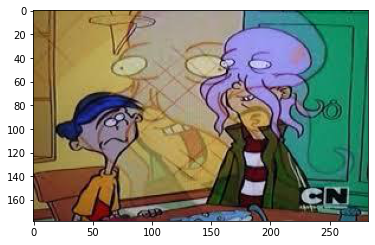

(1, 2048)
Caption: two people are sitting on benches in front of large gathering of people
_____________________________________


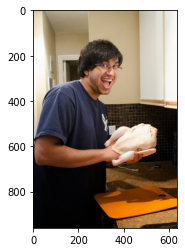

(1, 2048)
Caption: man in white shirt is sitting on bed with his hands on the table
_____________________________________


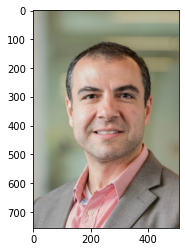

(1, 2048)
Caption: man with shaved head and sunglasses is standing in front of an
_____________________________________


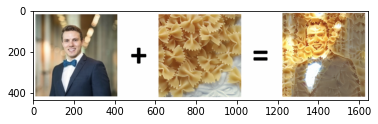

(1, 2048)
Caption: woman in red shirt is standing in front of large gathering of people
_____________________________________


In [38]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

urls = [
"https://i.ibb.co/k6fx26D/IMG-1148.jpg",
"https://raw.githubusercontent.com/AndresPitta/picture/master/foto2_modified.JPG",
"https://upload.wikimedia.org/wikipedia/en/2/28/Flop_Starz.jpg",
"https://raw.githubusercontent.com/hwilliams10/photos/master/rio_tevez.jpg", 
"https://raw.githubusercontent.com/sreejithmunthikodu/Files/master/1.jpg",
"https://raw.githubusercontent.com/mirohu/Coopie/master/photos/cooper_backseat.JPG",
"https://raw.githubusercontent.com/kfoofw/photos_ellie/master/ellie_high_trip.jpeg",
"https://www.nasa.gov/sites/default/files/images/273242main_EC01-0129-17_full_full.jpg",
"https://raw.githubusercontent.com/hwilliams10/photos/master/cari.jpg",
"https://raw.githubusercontent.com/kvarada/DSCI575/master/32081575_10156402668526663_2823271235624894464_o.jpg",
"https://raw.githubusercontent.com/kvarada/DSCI575/master/Reyes_magos_2018.jpg",
"https://raw.githubusercontent.com/kvarada/DSCI575/master/images_Tani.jpeg",
"https://raw.githubusercontent.com/kvarada/DSCI575/master/chicken.jpg",
"https://raw.githubusercontent.com/kvarada/DSCI575/master/milad.jpg",
"https://raw.githubusercontent.com/kvarada/DSCI575/master/screen_shot_2020-03-25_at_10.59.52_am.jpg"
]

for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()

  plt.imshow(img)
  plt.show()
  
  response = requests.get(url)

  img = encodeImage(img).reshape((1,OUTPUT_DIM))
  print(img.shape)
  print("Caption:",generateCaption(img))
  print("_____________________________________")